## Options Valuation

This notebook is an exploratory analysis of options valuation for trading strategies. The goal is to investigate  valuation of Swedish large-cap stock options and create templates that can be productionalized. These templates will be in the areas of 1) Covered call, 2) Vertical spread (Bull call, Bear put),  3) Iron Condor, 4) Straddle, 5) Strangle, 6) Butterfly Spread, 7) Naked call, and more. 

## Visualisation

In [2]:
#PnL diagram and distribution visualisation with thresholds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [23]:
#Proxy data from BTC
btc_data_filepath = "data/BTC_CoinDesk.csv"
#Read BTC data from file
delim1 = ","
btcdata = pd.read_csv(btc_data_filepath, sep=delim1)
btcdata["Date"] = pd.DataFrame([x[0:10] for x in btcdata["date_UTC"]])
btcdata=btcdata.dropna()
btcdata["price_return"] = btcdata["price_USD"].pct_change()
btcdata = btcdata[["Date","price_USD","price_return"]]
btcdata=btcdata.dropna()
#btcdata["price_return"] = np.log(btcdata["price_return"])
btcdata.head()

,Date,price_USD,price_return
1,2013-10-02,125.58083,0.018830
2,2013-10-03,100.81083,-0.197243
3,2013-10-04,116.96700,0.160262
4,2013-10-05,121.17883,0.036009
5,2013-10-06,121.18516,0.000052


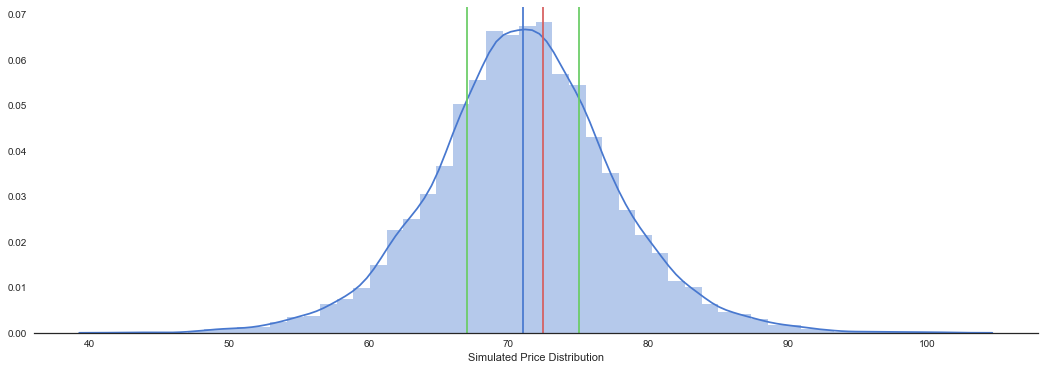

In [84]:
#Simulate data from empirical distribution
last_price = 70
days_forward = 5
sample_days_back = 1000
n_prices = 10000
strike = 72.5

def simulateForwardValue(price_start, days_forward, df_sample):
    pct_sum = np.sum(df_sample.sample(n=days_forward,replace=True))
    fwd_incr = 1+pct_sum #simple assumption, linear and independent path
    return price_start*fwd_incr

def simulateForwardDistribution(sim_len, price_start, days_forward, df_sample):
    sim_data = []
    for i in range(0,sim_len):
        sim_data.append(simulateForwardValue(price_start,days_forward,df_sample))
    return pd.DataFrame({'simulation_results':sim_data})

def getEmpProbGreater(threshold,df_sample):
    tot_count = df_sample.count()
    thres_count = df_sample[df_sample > threshold].dropna().count().values
    result = 0
    if tot_count.values > 0.0:
        result = thres_count/tot_count
    return result

simdata = simulateForwardDistribution(n_prices,last_price,days_forward,btcdata["price_return"].iloc[len(btcdata)-sample_days_back:len(btcdata)])
res = simdata.describe()
t_25 = res[4:5].values[0][0]
s_mean = simdata["simulation_results"].mean()
t_75 = res[6:7].values[0][0]

sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(18, 6), sharex=False)
sns.despine(left=True)
ax = sns.distplot(simdata, kde=True, color="b")
ax.set(xlabel=f'Simulated Price Distribution') #{var}

plt.axvline(t_25, 0, 1, color='g') 
plt.axvline(s_mean, 0, 1, color='b') 
plt.axvline(t_75, 0,1, color='g') 
plt.axvline(strike, 0,1, color='r') 

In [87]:
b = getEmpProbGreater(strike,simdata) #sample probability that price > strike in simulated distribution

In [88]:
a = getEmpProbGreater(last_price,simdata)
a-b

simulation_results    0.1662
dtype: float64

In [15]:
np.exp(1)

2.7182818284590451

In [81]:
len(btcdata)

1933